In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Dataset

In [20]:
os.environ['KAGGLE_USERNAME'] = "siddharthbohara"
os.environ['KAGGLE_KEY'] = "KGAT_c9b654bf1af1b9b90046fed85485637a"

In [12]:
!pip install -q kaggle

In [13]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other




  0%|          | 0.00/2.29G [00:00<?, ?B/s]
  0%|          | 1.00M/2.29G [00:01<1:00:29, 679kB/s]
  0%|          | 2.00M/2.29G [00:01<29:59, 1.37MB/s] 
  0%|          | 3.00M/2.29G [00:01<18:54, 2.17MB/s]
  0%|          | 5.00M/2.29G [00:02<10:01, 4.09MB/s]
  0%|          | 7.00M/2.29G [00:02<06:34, 6.23MB/s]
  0%|          | 9.00M/2.29G [00:02<04:56, 8.27MB/s]
  0%|          | 11.0M/2.29G [00:02<03:54, 10.4MB/s]
  1%|          | 13.0M/2.29G [00:02<03:29, 11.7MB/s]
  1%|          | 15.0M/2.29G [00:02<03:02, 13.4MB/s]
  1%|          | 17.0M/2.29G [00:02<02:49, 14.4MB/s]
  1%|          | 19.0M/2.29G [00:02<02:37, 15.5MB/s]
  1%|          | 21.0M/2.29G [00:03<02:35, 15.7MB/s]
  1%|          | 23.0M/2.29G [00:03<02:31, 16.1MB/s]
  1%|          | 25.0M/2.29G [00:03<02:26, 16.6MB/s]
  1%|          | 27.0M/2.29G [00:03<02:28, 16.4MB/s]
  1%|          | 29.0M/2.29G [00:03<02:22, 17.0MB/s]
  1%|▏         | 31.0M/2.29G [00:03<02:27, 16.5MB/s]
  1%|▏         | 34.0M/2.29G [00:03<02:19, 17.4MB/s]

In [14]:
!unzip -q chest-xray-pneumonia.zip

In [16]:
!rm chest-xray-pneumonia.zip

'rm' is not recognized as an internal or external command,
operable program or batch file.


Validation Set

In [21]:
def rebalance_validation_set():
    # Move original validation to train
    for cls in ['NORMAL', 'PNEUMONIA']:
        val_path = f'chest_xray/val/{cls}'
        train_path = f'chest_xray/train/{cls}'
        if os.path.exists(val_path):
            for file in os.listdir(val_path):
                shutil.move(os.path.join(val_path, file), os.path.join(train_path, file))

    # Re-split train into train/val
    for cls in ['NORMAL', 'PNEUMONIA']:
        files = [f for f in os.listdir(f'chest_xray/train/{cls}') if f.endswith('.jpeg')]
        train_files, val_files = train_test_split(files, test_size=0.1, random_state=42)
        os.makedirs(f'chest_xray/val/{cls}', exist_ok=True)
        for f in val_files:
            shutil.move(os.path.join(f'chest_xray/train/{cls}', f), os.path.join(f'chest_xray/val/{cls}', f))

rebalance_validation_set()

In [22]:
def preprocess_image(img_array):
    """Apply classical CV techniques to image array (H, W, C) in [0, 255]."""
    # Convert to uint8
    img_array = np.clip(img_array * 255, 0, 255).astype(np.uint8)
    
    # Grayscale conversion
    if img_array.shape[-1] == 3:
        gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    else:
        gray = img_array.squeeze()
    
    # CLAHE enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    
    # Gaussian blur
    blurred = cv2.GaussianBlur(enhanced, (5,5), 0)
    
    # Canny edge detection
    edges = cv2.Canny(blurred, 30, 150)
    
    # Resize
    enhanced_resized = cv2.resize(enhanced, (224, 224))
    edges_resized = cv2.resize(edges, (224, 224))
    
    # To RGB
    enhanced_rgb = cv2.cvtColor(enhanced_resized, cv2.COLOR_GRAY2RGB)
    
    # Normalize
    return enhanced_rgb.astype(np.float32) / 255.0

In [23]:
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

In [24]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_image
)

In [25]:
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)

In [30]:
BATCH_SIZE = 32

In [31]:
train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=BATCH_SIZE, class_mode='binary'
)

Found 4708 images belonging to 2 classes.


In [32]:
val_gen = val_test_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

Found 524 images belonging to 2 classes.


In [33]:
test_gen = val_test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

Found 624 images belonging to 2 classes.


In [34]:
class_names = ['NORMAL', 'PNEUMONIA']

In [35]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
class_weight_dict = dict(enumerate(class_weights))

In [36]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [37]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [38]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-7, mode='max')

In [39]:
print("Training classification head...")
history_head = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr]
)

Training classification head...
Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.6805 - loss: 0.6066 - val_accuracy: 0.6565 - val_loss: 0.6350 - learning_rate: 0.0010
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 145s 978ms/step - accuracy: 0.7407 - loss: 0.5469 - val_accuracy: 0.6584 - val_loss: 0.6431 - learning_rate: 0.0010
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.7500 - loss: 0.5278 - val_accuracy: 0.6527 - val_loss: 0.6563 - learning_rate: 0.0010
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 148s 995ms/step - accuracy: 0.7589 - loss: 0.5123 - val_accuracy: 0.6679 - val_loss: 0.5606 - learning_rate: 0.0010
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 148s 996ms/step - accuracy: 0.7581 - loss: 0.5214 - val_accuracy: 0.6737 - val_loss: 0.5670 - learning_rate: 0.0010
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.7610 - loss: 0.5082 - val_accuracy: 0.6489 - val_loss: 0.6664 - learning_rate: 0.0010
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1

In [51]:
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Unfreeze top 50 layers (more adaptation)
    layer.trainable = False

# Recompile with lower LR and add Recall metric
model.compile(
    optimizer=Adam(learning_rate=5e-6),  # Lower for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]  # Focus on Pneumonia recall
)

print("Fine-tuning top 50 layers with lower LR...")

Fine-tuning top 50 layers with lower LR...


In [52]:
history_fine = model.fit(
    train_gen,
    epochs=20,  # More epochs
    validation_data=val_gen,
    class_weight=class_weight_dict,
    callbacks=[
        EarlyStopping(monitor='val_recall', patience=8, restore_best_weights=True, mode='max'),  # Monitor recall
        ReduceLROnPlateau(monitor='val_recall', factor=0.5, patience=4, min_lr=1e-7, mode='max')
    ],
    verbose=1
)

Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.8458 - loss: 0.3854 - recall: 0.8369 - val_accuracy: 0.6908 - val_loss: 0.6385 - val_recall: 0.6067 - learning_rate: 5.0000e-06
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.8469 - loss: 0.3758 - recall: 0.8371 - val_accuracy: 0.7233 - val_loss: 0.5218 - val_recall: 0.6504 - learning_rate: 5.0000e-06
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.8449 - loss: 0.3885 - recall: 0.8354 - val_accuracy: 0.7405 - val_loss: 0.4685 - val_recall: 0.6761 - learning_rate: 5.0000e-06
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.8428 - loss: 0.3977 - recall: 0.8337 - val_accuracy: 0.6927 - val_loss: 0.6087 - val_recall: 0.6093 - learning_rate: 5.0000e-06
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.8432 - loss: 0.3774 - recall: 0.8283 - val_accuracy: 0.7290 - val_loss: 0.5098 - val_recall: 0.6607 - learning_rate: 5.0000e-06
Epoch 6/20
148/148 ━━━━━━

In [53]:
history = {k: history_head.history[k] + history_fine.history[k] for k in history_head.history}

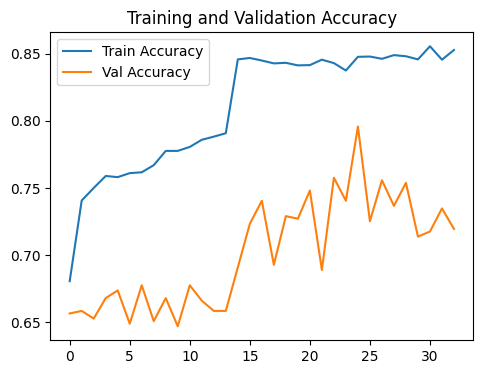

In [54]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

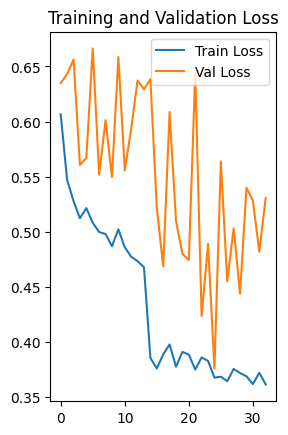

In [55]:
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [58]:
for key in history_fine.history:
    if key in history_head.history:
        history_head.history[key] += history_fine.history[key]
    else:
        history_head.history[key] = history_fine.history[key]

In [59]:
test_loss, test_acc, test_recall = model.evaluate(test_gen)
print(f"Updated Test Accuracy: {test_acc*100:.2f}%")
print(f"Updated Test Recall (Pneumonia): {test_recall*100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 713ms/step - accuracy: 0.6923 - loss: 0.7021 - recall: 0.7077
Updated Test Accuracy: 69.23%
Updated Test Recall (Pneumonia): 70.77%


In [60]:
y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_gen.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 807ms/step


In [62]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.58      0.67      0.62       234
   PNEUMONIA       0.78      0.71      0.74       390

    accuracy                           0.69       624
   macro avg       0.68      0.69      0.68       624
weighted avg       0.70      0.69      0.70       624



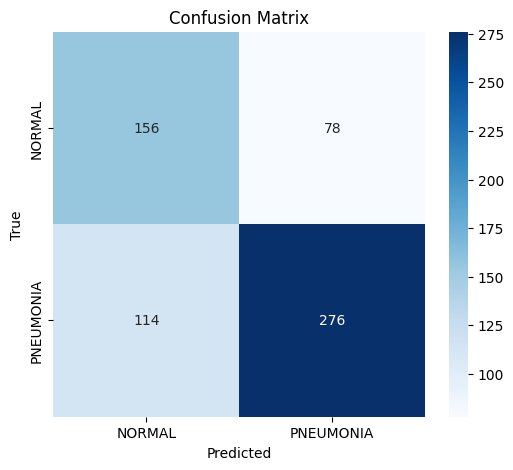

In [63]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

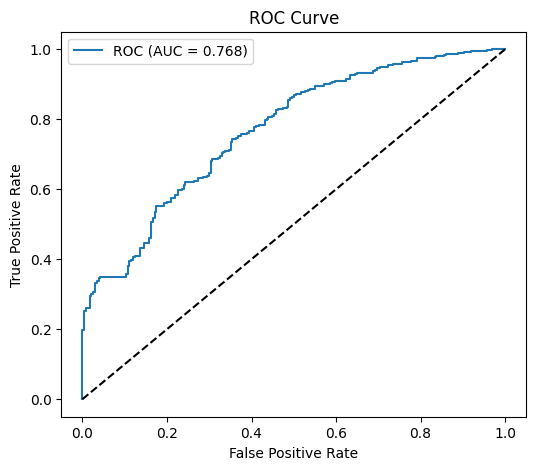

In [64]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
auc = roc_auc_score(y_true, y_pred_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [65]:
model.save('pneumonia_detection_model.h5')
print("Model saved as 'pneumonia_detection_model.h5'")

Model saved as 'pneumonia_detection_model.h5'


In [66]:
print("""
requirements.txt content:
tensorflow==2.15.0
opencv-python==4.9.0
scikit-learn==1.3.2
matplotlib==3.8.2
seaborn==0.13.2
kaggle==1.6.14
numpy==1.24.3
""")


requirements.txt content:
tensorflow==2.15.0
opencv-python==4.9.0
scikit-learn==1.3.2
matplotlib==3.8.2
seaborn==0.13.2
kaggle==1.6.14
numpy==1.24.3

